Objective: Reduce days in AR by predicting which outstanding accounts are most likely to become bad debts.
Approach: Implement a machine learning model to analyze account characteristics and payment history to prioritize AR follow-up. This allows for more efficient allocation of resources toward accounts that are most at risk

In [1]:
import pandas as pd
import numpy as np
import random

# Set a random seed for reproducibility
np.random.seed(0)

# Number of samples
n = 1000

# Generate synthetic data
data = {
    'Account_ID': np.arange(1, n + 1),
    'Balance': np.random.uniform(100, 1000, n),  # balance due
    'Days_Bill_Outstanding': np.random.randint(15, 365, n),  # days unpaid
    'Previous_Payment_Days': np.random.randint(30, 365, n),  # previous payment behavior
    'Number_of_Previous_Missed_Payments': np.random.randint(0, 10, n),  # missed payments
    'Age': np.random.randint(18, 80, n),  # age of the account holder
    'Income_Level': np.random.choice(['Low', 'Medium', 'High'], n),  # income level
    'Chronic': np.random.choice([0, 1], n)  # chronic condition
}

# Create a DataFrame
df = pd.DataFrame(data)

# Define a function to classify if an account is at high risk of becoming a bad debt
def classify_risk(row):
    # Consider an account high risk based on several conditions
    if (
        row['Days_Bill_Outstanding'] > 180 or 
        row['Number_of_Previous_Missed_Payments'] > 3 or 
        (row['Balance'] > 500 and row['Previous_Payment_Days'] > 200) or 
        (row['Income_Level'] == 'Low' and row['Chronic'] == 1)
    ):
        return 1
    else:
        return 0

# Apply the function to each row
df['Risk_of_Bad_Debt'] = df.apply(classify_risk, axis=1)

df.head()


,Account_ID,Balance,Days_Bill_Outstanding,Previous_Payment_Days,Number_of_Previous_Missed_Payments,Age,Income_Level,Chronic,Risk_of_Bad_Debt
0,1,593.932154,96,185,4,55,Medium,1,1
1,2,743.670430,44,120,0,58,High,1,0
2,3,642.487038,213,64,6,58,Medium,1,1
3,4,590.394865,43,356,6,70,Medium,1,1
4,5,481.289319,217,67,3,71,Medium,0,1


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Separate features and target
X = df.drop('Risk_of_Bad_Debt', axis=1)
y = df['Risk_of_Bad_Debt']

# Columns for transformation
num_features = ['Balance', 'Days_Bill_Outstanding', 'Previous_Payment_Days', 
                'Number_of_Previous_Missed_Payments', 'Age']
cat_features = ['Income_Level', 'Chronic']

# Create transformers
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Fit the preprocessor on the training data and transform the training and test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train.shape, X_test.shape


((800, 10), (200, 10))

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=0)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predictions
train_preds = rf_classifier.predict(X_train)
test_preds = rf_classifier.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

train_precision = precision_score(y_train, train_preds)
test_precision = precision_score(y_test, test_preds)

train_recall = recall_score(y_train, train_preds)
test_recall = recall_score(y_test, test_preds)

train_f1 = f1_score(y_train, train_preds)
test_f1 = f1_score(y_test, test_preds)

train_roc_auc = roc_auc_score(y_train, train_preds)
test_roc_auc = roc_auc_score(y_test, test_preds)

# Compile the metrics
metrics = {
    "Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy,
    "Train Precision": train_precision, "Test Precision": test_precision,
    "Train Recall": train_recall, "Test Recall": test_recall,
    "Train F1 Score": train_f1, "Test F1 Score": test_f1,
    "Train ROC AUC": train_roc_auc, "Test ROC AUC": test_roc_auc
}

conf_matrix = confusion_matrix(y_test, test_preds)

metrics, conf_matrix


({'Train Accuracy': 1.0,
  'Test Accuracy': 0.98,
  'Train Precision': 1.0,
  'Test Precision': 0.9781420765027322,
  'Train Recall': 1.0,
  'Test Recall': 1.0,
  'Train F1 Score': 1.0,
  'Test F1 Score': 0.988950276243094,
  'Train ROC AUC': 1.0,
  'Test ROC AUC': 0.9047619047619048},
 array([[ 17,   4],
        [  0, 179]], dtype=int64))

#Further im interested in looking at visuals of my input and output metrics

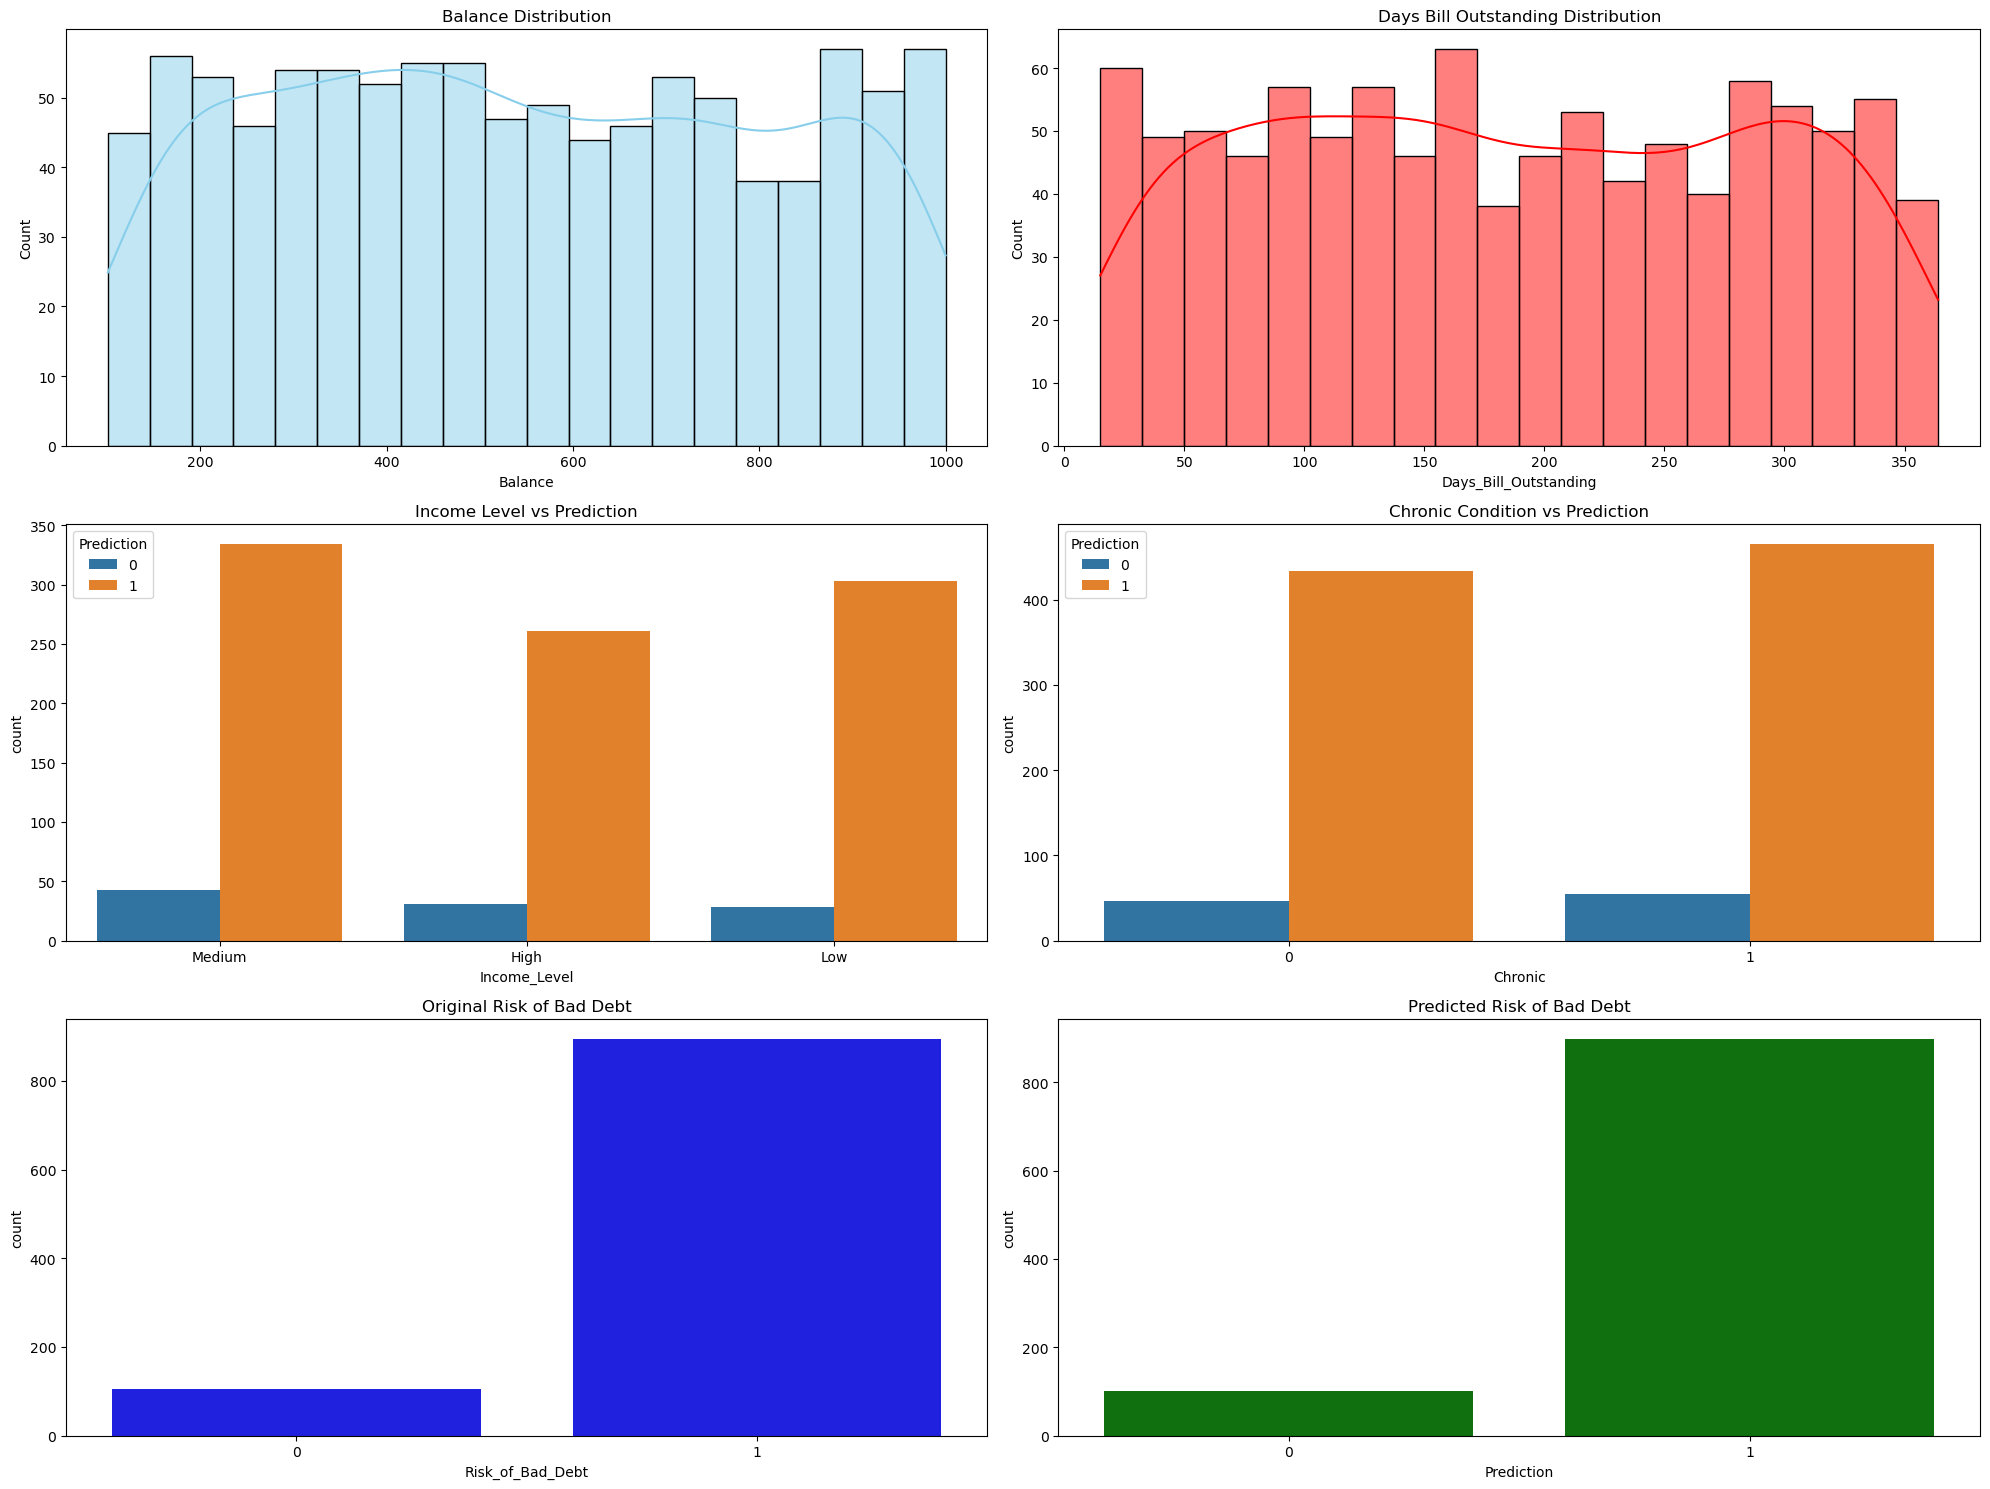

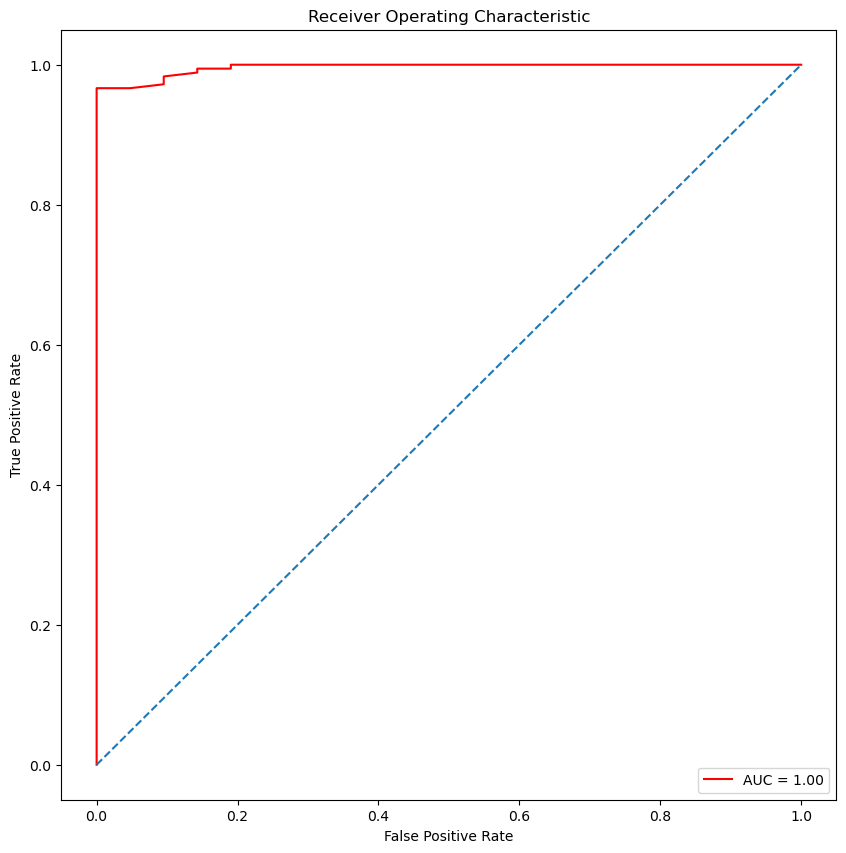

(   Account_ID     Balance  Days_Bill_Outstanding  Previous_Payment_Days  \
 0           1  593.932154                     96                    185   
 1           2  743.670430                     44                    120   
 2           3  642.487038                    213                     64   
 3           4  590.394865                     43                    356   
 4           5  481.289319                    217                     67   
 
    Number_of_Previous_Missed_Payments  Age Income_Level  Chronic  \
 0                                   4   55       Medium        1   
 1                                   0   58         High        1   
 2                                   6   58       Medium        1   
 3                                   6   70       Medium        1   
 4                                   3   71       Medium        0   
 
    Risk_of_Bad_Debt  Prediction  
 0                 1           1  
 1                 0           1  
 2                 1 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Adding the predictions to the original dataset
# First, we need to reverse the transformations applied to our dataset
# We concatenate the train and test sets first
X_all = np.concatenate((X_train, X_test), axis=0)

# Since we have applied a ColumnTransformer (which contains a OneHotEncoder for categorical features),
# we can't directly reverse the transformation. Instead, we'll add predictions to the original dataframe.
df['Prediction'] = np.concatenate((train_preds, test_preds), axis=0)

# Visualization of input features
# We will plot the distribution of a few input features for a better understanding
plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
sns.histplot(df['Balance'], kde=True, bins=20, color='skyblue')
plt.title('Balance Distribution')

plt.subplot(3, 2, 2)
sns.histplot(df['Days_Bill_Outstanding'], kde=True, bins=20, color='red')
plt.title('Days Bill Outstanding Distribution')

plt.subplot(3, 2, 3)
sns.countplot(x='Income_Level', hue='Prediction', data=df)
plt.title('Income Level vs Prediction')

plt.subplot(3, 2, 4)
sns.countplot(x='Chronic', hue='Prediction', data=df)
plt.title('Chronic Condition vs Prediction')

plt.subplot(3, 2, 5)
sns.countplot(x='Risk_of_Bad_Debt', data=df, color='blue')
plt.title('Original Risk of Bad Debt')

plt.subplot(3, 2, 6)
sns.countplot(x='Prediction', data=df, color='green')
plt.title('Predicted Risk of Bad Debt')

plt.tight_layout()
plt.show()

# For the output metric, we'll visualize the ROC curve
test_probs = rf_classifier.predict_proba(X_test)[:, 1]  # we only need probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color='red', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

df.head(), conf_matrix


In [8]:
df['Predictions'] = np.concatenate((train_preds, test_preds), axis=0)


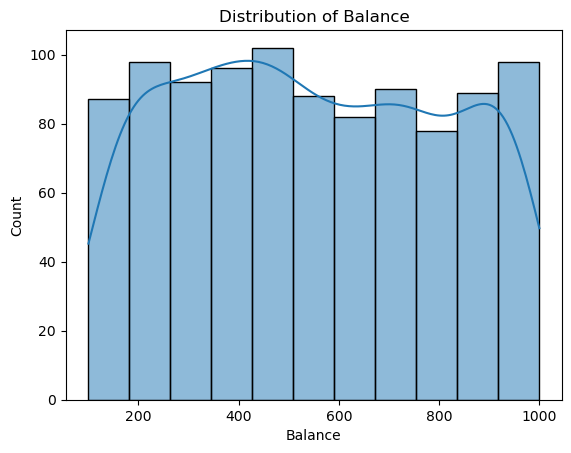

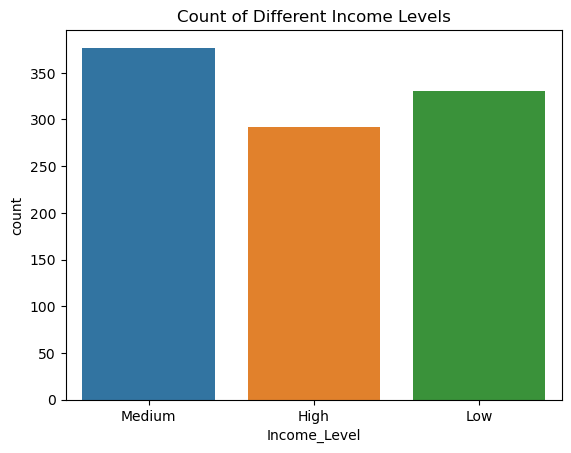

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram for viewing distribution of a numerical column
sns.histplot(df['Balance'], kde=True)
plt.title('Distribution of Balance')
plt.show()

# Bar plot for a categorical column
sns.countplot(x='Income_Level', data=df)
plt.title('Count of Different Income Levels')
plt.show()


C:\Users\laptop\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


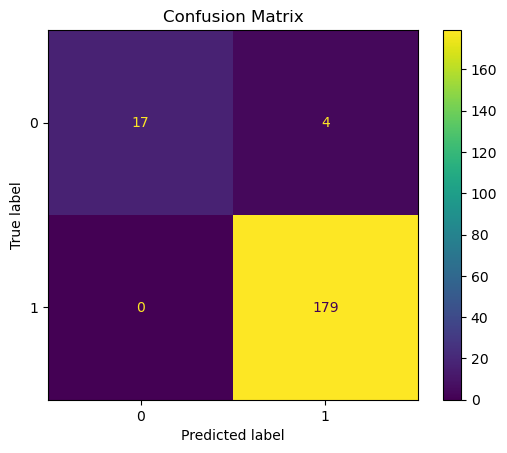

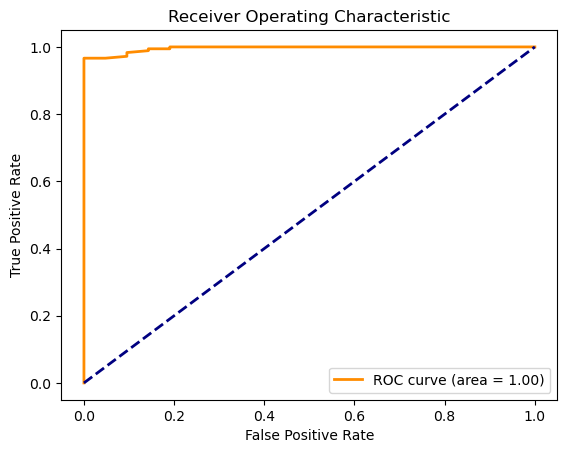

In [10]:
from sklearn.metrics import plot_confusion_matrix, roc_curve, auc

# Confusion matrix
plot_confusion_matrix(rf_classifier, X_test, y_test)  
plt.title('Confusion Matrix')
plt.show()

# ROC curve
probs = rf_classifier.predict_proba(X_test)
probs = probs[:, 1]  # probability for the positive outcome
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
